In [ ]:
pip install torchvision

In [31]:
pip install streamlit

     |████████████████████████████████| 9.1 MB 11.0 MB/s eta 0:00:01��███████████████             | 5.4 MB 11.0 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 12.6 MB/s eta 0:00:01
     |████████████████████████████████| 164 kB 74.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 64.8 MB/s eta 0:00:01
     |████████████████████████████████| 727 kB 63.3 MB/s eta 0:00:01
     |████████████████████████████████| 4.2 MB 72.3 MB/s eta 0:00:01 eta 0:00:01
     |████████████████████████████████| 235 kB 77.4 MB/s eta 0:00:01
     |████████████████████████████████| 70 kB 19.2 MB/s eta 0:00:01
     |████████████████████████████████| 51 kB 16.0 MB/s eta 0:00:01
     |████████████████████████████████| 339 kB 62.1 MB/s eta 0:00:01| 215 kB 62.1 MB/s eta 0:00:01
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19567 sha256=326cd73c748eff58e603ca992f6b975305976f588c46e4858beb9cc82ef37627
  Stored in directory: /home/jovyan/.cache/pip/wheel

In [33]:
pip install vaderSentiment

     |████████████████████████████████| 125 kB 20.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
!nvidia-smi

Tue Aug  9 12:16:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.130      Driver Version: 418.130      CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GRID V100DX-8Q      On   | 00000000:00:06.0 Off |                  N/A |
| N/A   N/A    P0    N/A /  N/A |    528MiB /  8192MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
!pip install torch==1.7.0 torchvision==0.8.1 -f https://download.pytorch.org/whl/cu101/torch_stable.html

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torchvision import models, transforms, datasets
from PIL import Image


In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
print(DEVICE)

cuda


00:



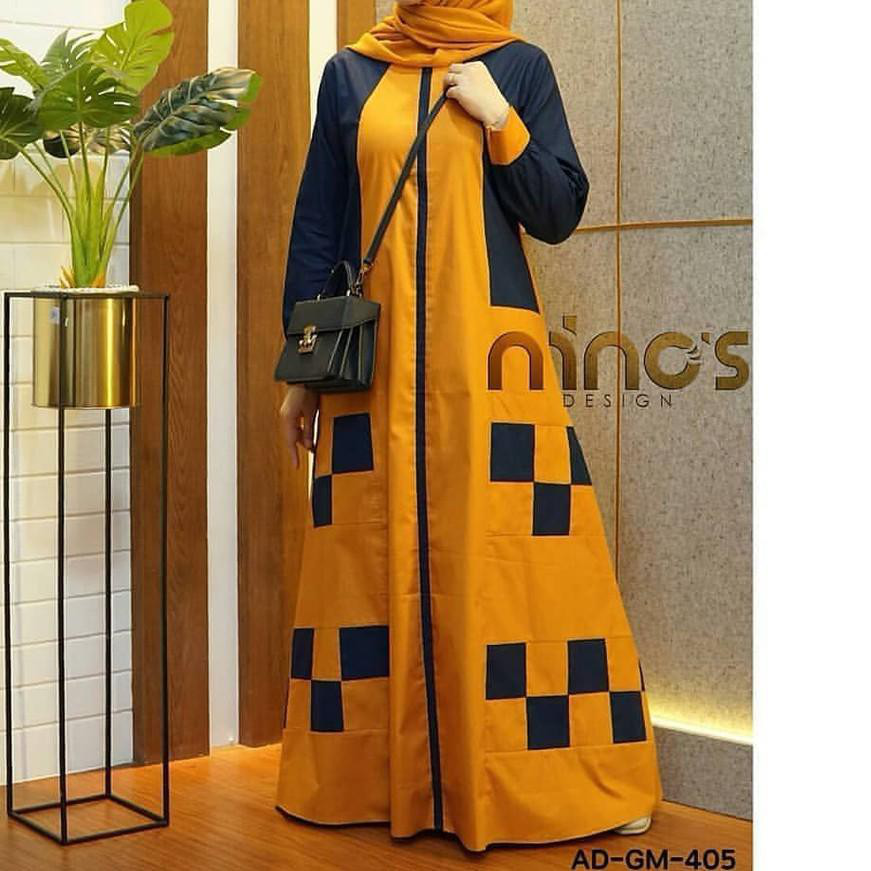

In [4]:

class ImageFolderWithPaths(datasets.ImageFolder):
  
    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


print('00:\n')
Image.open('train/train/00/00b32bd5ba9cdd7c2f11e3975b3e54fa.jpg')

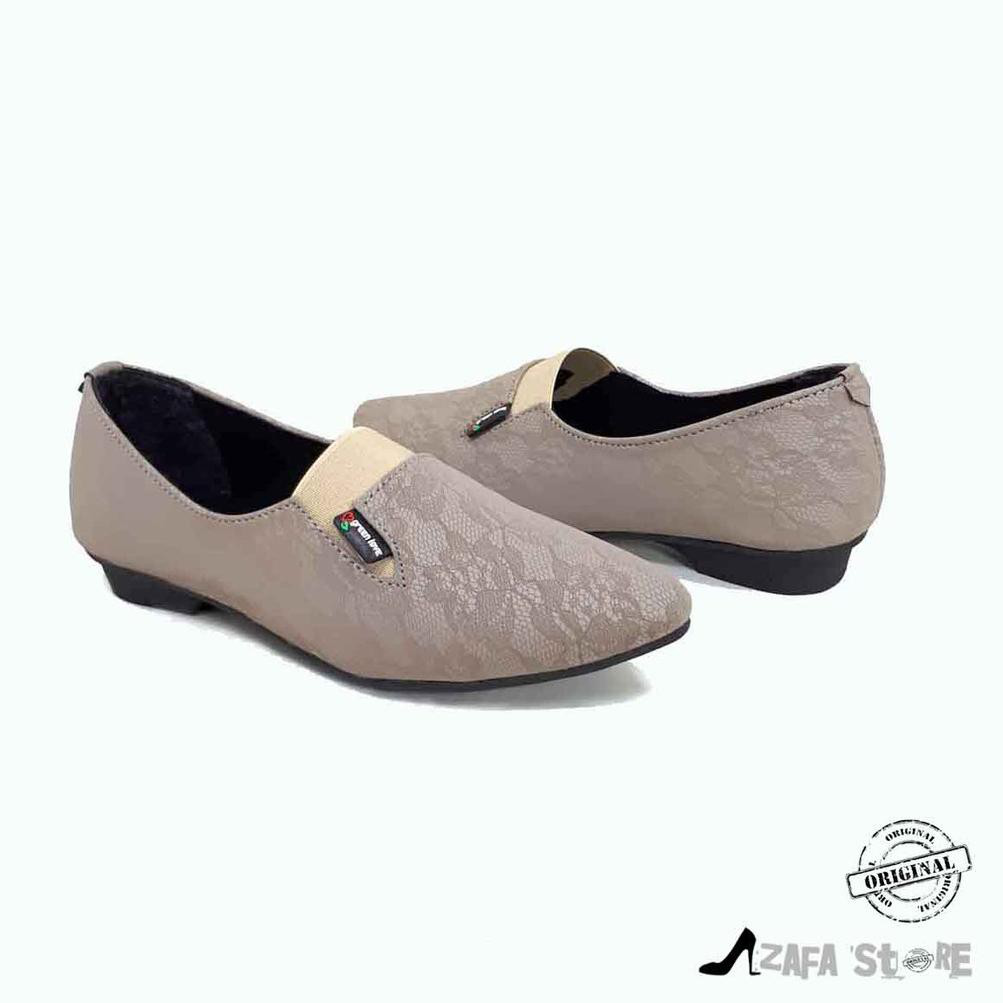

In [5]:

Image.open('test/test/00ae48234db59bfdf2e23f6061429ab0.jpg')

In [11]:
#preprocess images
transforms_ = transforms.Compose([
    transforms.Resize(size=[224, 224], interpolation=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

dataset = ImageFolderWithPaths('train/train/', transforms_) # our custom dataset

#define dataloader
BATCH = 1
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH)

In [8]:
import torchvision.models as models

resnet18 = models.resnet18(pretrained=True)


In [9]:

def pooling_output(x):
    #write your code here
  for layer_name, layer in resnet18._modules.items():
    #layer_name = layer_name.cuda()
    layer = layer.cuda()
    x = layer(x)
    if layer_name == 'avgpool':
        break
    #print(x.shape)
  return x.view(BATCH,-1)


In [12]:
vec_img_list = []

with torch.no_grad():
    resnet18.eval()
    for item, (inputs, labels, paths) in enumerate(dataloader):
        print("Batch {}/{}".format(item,len(dataloader)), end='\r')
        inputs = inputs.to(DEVICE)
        #print("Shape of input : ", inputs.shape)
        
        img_vec = pooling_output(inputs)
        vec_img_list += [(img_vec.cpu(), paths[0])]
        torch.cuda.empty_cache()


Time taken to retrieve:  8.068676948547363  seconds


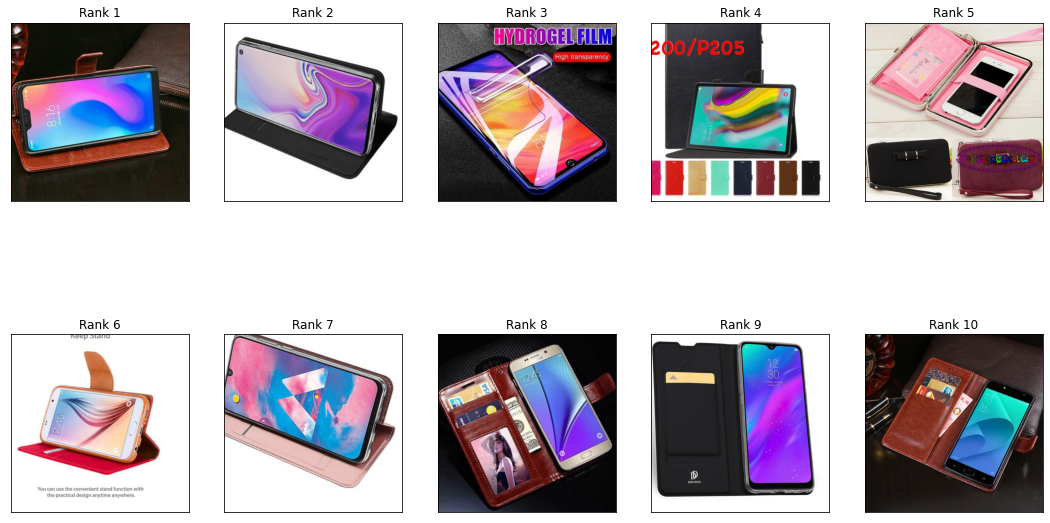

In [51]:
import time
import matplotlib.pyplot as plt

#query image
query_image = 'test/test/0a7cebae9c84961ea176d6083101f03e.jpg'
start_time = time.time()
img = Image.open(query_image)

#transform the query img to vector and reshape it
input_tensor = transforms_(img)

input_tensor = input_tensor.view(1, *input_tensor.shape)



#obtain query_vector 
with torch.no_grad():
  input_tensor  = input_tensor.cuda()
  #print("Shape of input : ", input_tensor.shape)
  query_vector = pooling_output(input_tensor)
  query_vector = query_vector.cpu()
#reshape the query
query_vector = query_vector.reshape(1, 512)


cos = nn.CosineSimilarity(dim=1, eps=1e-6)

#find top 10 images in the data that match query image.
N = 10
cosine_scores_list = []
cosine_scores = {}

for i in range(len(vec_img_list)):
  temp_cos_score = cos(query_vector, vec_img_list[i][0])
  temp_cos_score = temp_cos_score.item()
  
  cosine_scores[temp_cos_score] = vec_img_list[i][1]
  #store in a list to sort 
  cosine_scores_list.append(temp_cos_score)


cosine_scores_list.sort(reverse= True)

top_N_similarity_scores = cosine_scores_list[:N:]
img_path_list = []
#retrieve the image path using the highest N similarity scores
for i in top_N_similarity_scores:

  img_path = cosine_scores[i]
  img_path_list.append(img_path)

fig, chungus = plt.subplots(2,5)
fig.set_size_inches(18.5, 10.5)
axes = [ax for axes in chungus for ax in axes]

for i in range(len(img_path_list)):
    axes[i].imshow(plt.imread(img_path_list[i]))
    axes[i].set_yticks([])
    axes[i].set_xticks([])
    axes[i].set_title(f'Rank {i+1}')

print('Time taken to retrieve: ', time.time()-start_time, ' seconds')